In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import plotly.express as px
from tqdm import tqdm
import warnings

import lightgbm as lgb

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, precision_recall_curve, roc_curve, auc 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Pre-defined Functions

In [2]:
def classifier_performance(Y, Y_hat, Y_score):
    fpr, tpr, thresholds_roc = roc_curve(Y, Y_score)
    roc_auc = auc(fpr, tpr)
    plt.rcParams.update({'font.size': 10})

    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate', fontsize = 10)
    plt.ylabel('True Positive Rate', fontsize = 10)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize = 10)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.legend(loc='best', fontsize = 10)
    plt.grid(True)
    plt.show()
    
    
    precision = precision_score(Y, Y_hat)
    recall = recall_score(Y, Y_hat)
    f1 = f1_score(Y, Y_hat)
    print(f"Precision: {round(precision, 4)}, Recall: {round(recall, 4)}, F1 score: {round(f1, 4)}, Accuracy: {round(np.sum(Y == Y_hat) / Y.shape[0], 4)}")

In [3]:
def standardizer(X_train, X_test):
    """
    features need to be standardize:
    Total Land Transfer Area, Total Building Transfer Area, Current Building Layout-Rooms, Current Building Layout-Living Rooms,
    Current Building Layout-Bathrooms, Total Parking Space Area, Total Parking Price, Main Building Area, Auxiliary Building Area,
    Balcony Area, Latitude, Longitude, Total Floors, Sale Floor, 'Age', Building land ratio, Main Building Percentage
    """
    features = ['Total Land Transfer Area', 'Total Building Transfer Area', 'Current Building Layout-Rooms', 'Current Building Layout-Living Rooms',
    'Current Building Layout-Bathrooms', 'Total Parking Space Area', 'Total Parking Price', 'Main Building Area', 'Auxiliary Building Area',
    'Balcony Area', 'Latitude', 'Longitude', 'Total Floors', 'Sale Floor', 'Age', 'Building land ratio', 'Main building percentage']
    X_c_train = X_train.copy()
    X_c_test = X_test.copy()

    for f in features:
        mean = X_c_train[f].mean()
        std = X_c_train[f].std()
        X_c_train[f] = (X_c_train[f] - mean)/ std
        X_c_test[f] = (X_c_test[f] - mean)/ std
        
    return X_c_train, X_c_test

In [4]:
def floor_preprocessing(X):
    warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

    X = X.copy()
    index = X[X['Total Floors'] == 0].index
    x = X.iloc[index]
    total_floors = [0] * x.shape[0]
    for i, j in enumerate(x['Building Type Residential Building (11 Floors and Above with Elevator)']):
        if j == 1:
            total_floors[i] = 11
    
    for i, j in enumerate(x['Building Type Apartment (5 Floors and Below without Elevator)']):
        if j == 1:
            total_floors[i] = 5
    
    for i, j in enumerate(x['Building Type Mansion (10 Floors and Below with Elevator)']):
        if j == 1:
            total_floors[i] = 10
    
    for i, j in enumerate(x['Building Type Detached House']):
        if j == 1:
            total_floors[i] = 4
            
    for i, j in enumerate(index):
        X['Total Floors'].iloc[j] = total_floors[i]
        X['Sale Floor'].iloc[j] = int(total_floors[i] / 2)
    
    index = X[X['Sale Floor'] == 0].index
    x = X.iloc[index]
    sale_floor = (x['Total Floors'] / 2).to_list()
    for i, j in enumerate(index):
        X['Sale Floor'].iloc[j] = int(sale_floor[i]) + 1
    
    return X

In [5]:
def district_price_dict(X, Y):
    X = X.copy()
    Y = Y.copy()
    try:
        X['Price'] = Y['Price']
    except:
        X['Price'] = Y
    
    taipei = ['District_Zhongzheng', 'District_Datong', 'District_Zhongshan', 'District_Songshan', "District_Da'an", 
              'District_Wanhua', 'District_Xinyi', 'District_Shilin', 'District_Beitou', 'District_Neihu', 'District_Nangang', 'District_Wenshan']
    X['Taipei'] = (X.loc[:, taipei].sum(axis = 1))
    
    price_dict = dict()
    price_dict['Taipei'] = X[X['Taipei'] == 1]['Price'].mean()
    price_dict['New Taipei'] = X[X['Taipei'] == 0]['Price'].mean()
    
    district = [i for i in X.columns if 'District' in i]
    for d in district:
        if X[X[d] == 1].shape[0] > 0:
            price_dict[d] = X[X[d] == 1]['Price'].mean()
        else:
            if d in taipei:
                price_dict[d] = price_dict['Taipei']
            else:
                price_dict[d] = price_dict['New Taipei']
                
    
    return price_dict

def parkingtype_dict(X, Y):
    X = X.copy()
    Y = Y.copy()
    try:
        X['Price'] = Y['Price']
    except:
        X['Price'] = Y
        
    price_dict = dict()
    parkingtype = ["Parking Type Flat on Ground Level", 
                    "Parking Type Other", "Parking Type Lift Plane", "Parking Type Lift Mechanical", 
                    "Parking Type Ramp Plane", "Parking Type Ramp Mechanical", 
                    "Parking Type Tower"]
    
    parking = [i for i in X.columns if 'Parking Type' in i]
    for p in parking:
        price_dict[p] = X[X[p] == 1]['Price'].mean()
    return price_dict

In [6]:
def district_preprocessing(X, price_dict):
    X = X.copy()
    district = [i for i in X.columns if 'District' in i]
    price = [0] * X.shape[0]
    for d in district:
        index = X[X[d] == 1].index
        for i in index:
            price[i] = price_dict[d]
    X['Dis_Price'] = price
    X['Dis_Price'] = (X['Dis_Price'] - X['Dis_Price'].mean())/ X['Dis_Price'].std()

    return X

def parkingtype_preprocessing(X, parking_dict):
    X = X.copy()
    parking = [i for i in X.columns if 'Parking Type' in i]
    price = [0] * X.shape[0]
    for p in parking:
        index = X[X[p] == 1].index
        for i in index:
            price[i] = parking_dict[p]
    X['ParkingType_Price'] = price
    X['ParkingType_Price'] = (X['ParkingType_Price'] - X['ParkingType_Price'].mean())/ X['ParkingType_Price'].std()
    return X


## Data Preprocessing

In [7]:
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
Y_train = pd.read_csv("y_train.csv")

In [8]:
translated_columns = [
    "Index", "Total Land Transfer Area", "Total Building Transfer Area", 
    "Current Building Layout-Rooms", "Current Building Layout-Living Rooms", 
    "Current Building Layout-Bathrooms", "Total Parking Space Area", 
    "Total Parking Price", "Main Building Area", "Auxiliary Building Area", 
    "Balcony Area", "Latitude", "Longitude", "Deal Year", "Deal Month", "Deal Day", 
    "Built Year", "Built Month", "Built Day", "Total Floors", "Sale Floor", 
    "District_Sanxia", "District_Sanzhi", "District_Sanchong", "District_Zhonghe", 
    "District_Zhongshan", "District_Zhongzheng", "District_Wugu", "District_Xinyi", 
    "District_Neihu", "District_Bali", "District_Beitou", "District_Nangang", 
    "District_Tucheng", "District_Pinglin", "District_Shilin", "District_Datong", 
    "District_Da'an", "District_Wenshan", "District_Xindian", "District_Xinzhuang", 
    "District_Songshan", "District_Banqiao", "District_Linkou", "District_Shulin", 
    "District_Yonghe", "District_Xizhi", "District_Taishan", "District_Tamsui", 
    "District_Shenkeng", "District_Ruifang", "District_Shiding", "District_Shimen", 
    "District_Wanhua", "District_Wanli", "District_Luzhou", "District_Gongliao", 
    "District_Jinshan", "District_Shuangxi", "District_Yingge", "Transaction Target Land+Building", 
    "Transaction Target Land+Building+Parking Space", "Building Type Residential Building (11 Floors and Above with Elevator)", 
    "Building Type Apartment (5 Floors and Below without Elevator)", "Building Type Other", 
    "Building Type Storefront", "Building Type Factory/Office", 
    "Building Type Mansion (10 Floors and Below with Elevator)", "Building Type Farmhouse", 
    "Building Type Detached House", "Building Current Layout-Partitions Yes", 
    "Building Current Layout-Partitions No", "Management Organization Yes", 
    "Management Organization No", "Parking Type Flat on Ground Level", 
    "Parking Type Other", "Parking Type Lift Plane", "Parking Type Lift Mechanical", 
    "Parking Type Ramp Plane", "Parking Type Ramp Mechanical", 
    "Parking Type Tower", "Elevator Yes", "Elevator No"
]
pd.set_option('display.max_columns', None)
X_train.columns = translated_columns
X_test.columns = translated_columns

In [9]:
# Drop unrelated columns
drop = ['Index', 'Deal Year', 'Deal Day', 'Built Day', 'Built Month', 'Management Organization No', 'Elevator No', 
        "Building Current Layout-Partitions Yes", 'Deal Year', 'Built Year', 'Transaction Target Land+Building+Parking Space']

# Floor preprocessing
X_train = floor_preprocessing(X_train)
X_test = floor_preprocessing(X_test)

# Add some features
X_train['Main building percentage'] = X_train['Main Building Area'] / X_train['Total Building Transfer Area']
X_test['Main building percentage'] = X_test['Main Building Area'] / X_test['Total Building Transfer Area']
X_train['Building land ratio'] = X_train['Total Building Transfer Area'] / X_train['Total Land Transfer Area']
X_test['Building land ratio'] = X_test['Total Building Transfer Area'] / X_test['Total Land Transfer Area']
X_train['Living floor ratio'] = X_train['Sale Floor'] / X_train['Total Floors']
X_test['Living floor ratio'] = X_test['Sale Floor'] / X_test['Total Floors']

# Drop irrelevant columns
X_train.drop(columns = ['Building Type Residential Building (11 Floors and Above with Elevator)', 'Building Type Mansion (10 Floors and Below with Elevator)', 'Building Type Apartment (5 Floors and Below without Elevator)', 'Building Type Farmhouse'], inplace = True)
X_test.drop(columns = ['Building Type Residential Building (11 Floors and Above with Elevator)', 'Building Type Mansion (10 Floors and Below with Elevator)', 'Building Type Apartment (5 Floors and Below without Elevator)', 'Building Type Farmhouse'], inplace = True)

# Drop an outlier built year = 2
X_train['Price'] = Y_train['Price']
X_train = X_train.drop([X_train[X_train['Built Year'] == 2].index[0]]) 
X_train = X_train.drop([X_train[X_train['Price'] == 0].index[0]])
X_train.reset_index(inplace = True, drop = True)

# Drop outliers
zero_land_index = X_train[X_train['Total Land Transfer Area'] < 0.01].index
X_train = X_train.drop(zero_land_index.to_list())
X_train.reset_index(inplace = True, drop = True)

Y_train = X_train['Price']
X_train = X_train.drop(columns = ['Price'])

# Assign the median value to built year = 0
X_train_builtyearmedian = X_train[X_train["Built Year"] != 0]["Built Year"].median()
X_train.loc[X_train["Built Year"] == 0, "Built Year"] = X_train_builtyearmedian
X_test.loc[X_test["Built Year"] == 0, "Built Year"] = X_train_builtyearmedian

# Age feature
X_train['Age'] = X_train['Deal Year'] - X_train['Built Year']
X_test['Age'] = X_test['Deal Year'] - X_test['Built Year']

X_train.drop(columns = drop, inplace = True)
X_test.drop(columns = drop, inplace = True)

# Standardize
X_train_standardize, X_test_standardize = standardizer(X_train, X_test)

In [10]:
# Get the index
taipei = ['District_Zhongzheng', 'District_Datong', 'District_Zhongshan', 'District_Songshan', "District_Da'an", 
              'District_Wanhua', 'District_Xinyi', 'District_Shilin', 'District_Beitou', 'District_Neihu', 'District_Nangang', 'District_Wenshan']

train_taipei_index = X_train_standardize[X_train_standardize[taipei].sum(axis = 1) == 1].index
train_newtaipei_index = np.where(~X_train_standardize.index.isin(train_taipei_index) == 1)[0]

test_taipei_index = X_test_standardize[X_test_standardize[taipei].sum(axis = 1) == 1].index
test_newtaipei_index = np.where(~X_test_standardize.index.isin(test_taipei_index) == 1)[0]

## Naive Regression

In [11]:
# Target encoding District and Parking Type
X_train_standardize_naive = district_preprocessing(X_train_standardize, district_price_dict(X_train, Y_train))
X_test_standardize_naive = district_preprocessing(X_test_standardize, district_price_dict(X_train, Y_train))

X_train_standardize_naive = parkingtype_preprocessing(X_train_standardize_naive, parkingtype_dict(X_train, Y_train))
X_test_standardize_naive = parkingtype_preprocessing(X_test_standardize_naive, parkingtype_dict(X_train, Y_train))

district = X_train_standardize_naive.columns[X_train_standardize_naive.columns.str.contains('District')]
X_train_standardize_naive = X_train_standardize_naive.drop(columns = district)
X_test_standardize_naive = X_test_standardize_naive.drop(columns = district)

parking = X_train_standardize_naive.columns[X_train_standardize_naive.columns.str.contains('Parking Type')]
X_train_standardize_naive = X_train_standardize_naive.drop(columns = parking)
X_test_standardize_naive = X_test_standardize_naive.drop(columns = parking)

<Axes: >

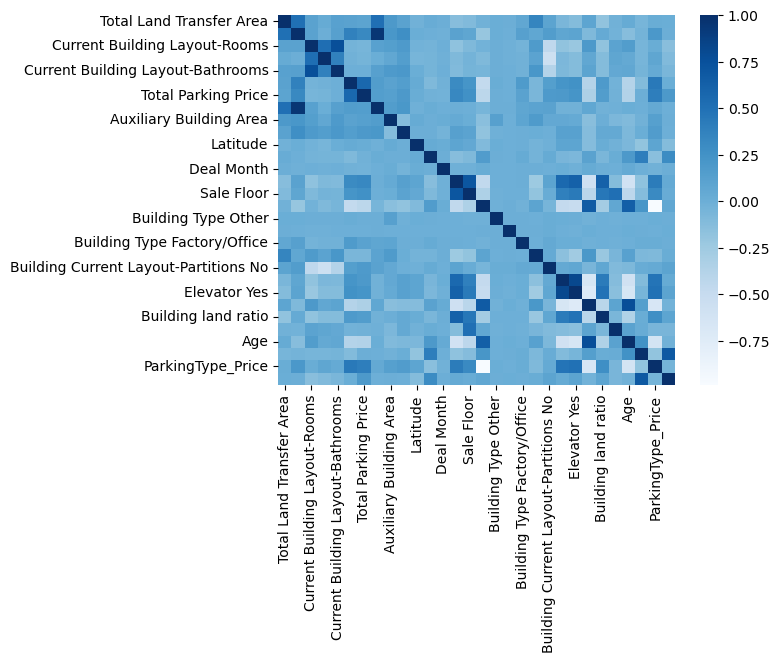

In [12]:
corr = pd.concat([X_train_standardize_naive, Y_train], axis = 1).corr()
sns.heatmap(corr, cmap="Blues", annot=False)

In [13]:
lightgbm_model_naive = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = 10, max_depth = 5, learning_rate = 0.05, n_estimators = 5000, verbose = -1)
lightgbm_model_naive.fit(X_train_standardize_naive, Y_train)
Y_hat_naive = lightgbm_model_naive.predict(X_train_standardize_naive)

train_index = X_train_standardize_naive.index
train_dict = {'index' : train_index, 'predict': Y_hat_naive}
train_pd = pd.DataFrame(train_dict)

district_col = [i for i in X_train.columns if 'District' in i]
training_error_data = {"District": [], "MAE": [], "Number": []}

for i in district_col:
    district_i_index = X_train[X_train[i] == 1][i].index
    Y_train_hat_district_i = train_pd['predict'].iloc[district_i_index]
    Y_train_district_i = Y_train.iloc[district_i_index]
    if Y_train_hat_district_i.shape[0]!= 0:
        MAE_gbm_i = mean_absolute_error(Y_train_district_i, Y_train_hat_district_i)
        training_error_data['District'].append(i)
        training_error_data['MAE'].append(MAE_gbm_i)
        training_error_data['Number'].append(Y_train_hat_district_i.shape[0])
    else:
        print(f"----------No training data in {i}----------")

print(f"Totol training data MAE of Naive regression: {round(mean_absolute_error(Y_hat_naive, Y_train), 4)}")
pd.DataFrame(training_error_data).sort_values(by = "MAE")

Y_test_hat = lightgbm_model_naive.predict(X_test_standardize_naive)
test_dict = {'Index' : X_test_standardize_naive.index, 'Price': Y_test_hat}
test_pd = pd.DataFrame(test_dict)
test_pd = test_pd.sort_values(by = 'Index')
date = time.ctime(time.time())[:10].replace(' ', '')
test_pd.to_csv(f"test_NaiveGBM_{date}.csv", index = False)

----------No training data in District_Shiding----------
Totol training data MAE of Naive regression: 12160.5883


In [14]:
district_col = [i for i in X_train.columns if 'District' in i]
training_mean_dict = {"District": [], "Predicted": [], "Real": []}

for i in district_col:
    district_i_index = X_train[X_train[i] == 1][i].index
    Y_train_hat_district_i = train_pd['predict'].iloc[district_i_index]
    Y_train_district_i = Y_train.iloc[district_i_index]
    if Y_train_hat_district_i.shape[0]!= 0:
        training_mean_dict['District'].append(i)
        training_mean_dict['Predicted'].append(Y_train_hat_district_i.mean())
        training_mean_dict['Real'].append(Y_train_district_i.mean())
    else:
        print(f"----------No training data in {i}----------")

pd.DataFrame(training_mean_dict)

----------No training data in District_Shiding----------


,District,Predicted,Real
0,District_Sanxia,86124.853585,86235.577167
1,District_Sanzhi,33134.903711,33312.238095
2,District_Sanchong,125963.232542,125693.897544
3,District_Zhonghe,130558.239679,130660.150786
4,District_Zhongshan,213912.638663,213672.921429
5,District_Zhongzheng,247208.179025,247936.617997
6,District_Wugu,87735.717598,86903.027692
7,District_Xinyi,240677.008665,240811.690418
8,District_Neihu,180490.663709,180260.337147
9,District_Bali,65831.111725,65530.567416


## Two Stage ML Model

(array([-2.50e+13,  0.00e+00,  2.50e+13,  5.00e+13,  7.50e+13,  1.00e+14,
         1.25e+14,  1.50e+14,  1.75e+14,  2.00e+14]),
 [Text(0, -25000000000000.0, '−0.25'),
  Text(0, 0.0, '0.00'),
  Text(0, 25000000000000.0, '0.25'),
  Text(0, 50000000000000.0, '0.50'),
  Text(0, 75000000000000.0, '0.75'),
  Text(0, 100000000000000.0, '1.00'),
  Text(0, 125000000000000.0, '1.25'),
  Text(0, 150000000000000.0, '1.50'),
  Text(0, 175000000000000.0, '1.75'),
  Text(0, 200000000000000.0, '2.00')])

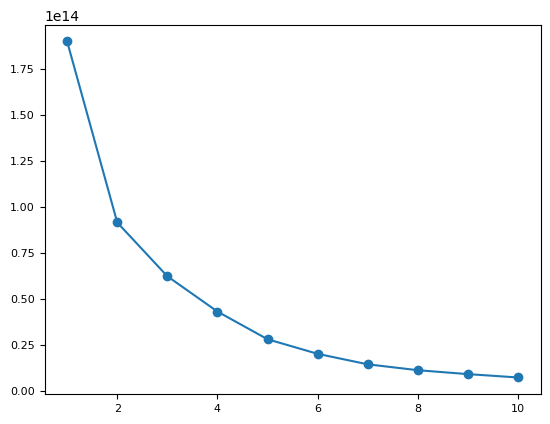

In [15]:
plt.rcParams.update({'font.size': 10})

inertia = []
for i in range(10):
    kmean = KMeans(n_clusters = i + 1, random_state = 0, n_init = 10)
    kmean.fit(Y_train.to_numpy().reshape(-1, 1))
    inertia.append(kmean.inertia_)
plt.plot([i + 1 for i in range(10)], inertia)
plt.scatter([i + 1 for i in range(10)], inertia)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)

In [16]:
kmean = KMeans(n_clusters = 2, random_state = 0, n_init = 10)
kmean.fit(Y_train.to_numpy().reshape(-1, 1))
X_label = kmean.predict(Y_train.to_numpy().reshape(-1, 1))
print(f"numbers of 1: {np.sum(X_label)}, numbers of 0: {X_label.shape[0] - np.sum(X_label)}")

numbers of 1: 6795, numbers of 0: 23201


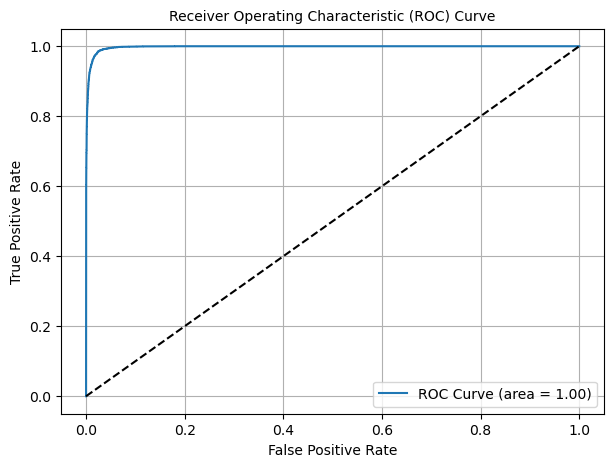

Precision: 0.9448, Recall: 0.9704, F1 score: 0.9575, Accuracy: 0.9805


In [17]:
classifier = lgb.LGBMClassifier(
                           boosting_type = 'gbdt', num_leaves = 10, 
                           max_depth = 6, learning_rate = 0.05, n_estimators = 5000, 
                           lambda_l1 = 3, lambda_l2 = 1, min_gain_to_split = 0.01,
                           bagging_freq = 10, scale_pos_weight = 1.5, feature_fraction = 0.6, verbose = -1
                          )
classifier.fit(X_train_standardize, X_label)
X_label_hat = classifier.predict(X_train_standardize) 
X_test_label_hat = classifier.predict(X_test_standardize) 
X_label_hat_prob = classifier.predict_proba(X_train_standardize)[:, 1]
classifier_performance(X_label, X_label_hat, X_label_hat_prob)

In [18]:
X_train_standardize = district_preprocessing(X_train_standardize, district_price_dict(X_train, Y_train))
X_test_standardize = district_preprocessing(X_test_standardize, district_price_dict(X_train, Y_train))

X_train_standardize = parkingtype_preprocessing(X_train_standardize, parkingtype_dict(X_train, Y_train))
X_test_standardize = parkingtype_preprocessing(X_test_standardize, parkingtype_dict(X_train, Y_train))

district = X_train_standardize.columns[X_train_standardize.columns.str.contains('District')]
X_train_standardize = X_train_standardize.drop(columns = district)
X_test_standardize = X_test_standardize.drop(columns = district)

parking = X_train_standardize.columns[X_train_standardize.columns.str.contains('Parking Type')]
X_train_standardize = X_train_standardize.drop(columns = parking)
X_test_standardize = X_test_standardize.drop(columns = parking)

In [19]:
lightgbm_model1 = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = 10, max_depth = 5, learning_rate = 0.05, n_estimators = 5000, verbose = -1)
lightgbm_model0 = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = 10, max_depth = 5, learning_rate = 0.05, n_estimators = 5000, verbose = -1)

train_1_index = np.where(X_label_hat == 1)[0]
train_0_index = np.where(X_label_hat == 0)[0]

test_1_index = np.where(X_test_label_hat == 1)[0]
test_0_index = np.where(X_test_label_hat == 0)[0]

lightgbm_model1.fit(X_train_standardize.iloc[train_1_index], Y_train.iloc[train_1_index])
lightgbm_model0.fit(X_train_standardize.iloc[train_0_index], Y_train.iloc[train_0_index])

Y_train_hat_gbm1 = lightgbm_model1.predict(X_train_standardize.iloc[train_1_index])
Y_train_hat_gbm0 = lightgbm_model0.predict(X_train_standardize.iloc[train_0_index])

train_index = np.concatenate([train_0_index, train_1_index], axis = 0)
Y_train_hat = np.concatenate([Y_train_hat_gbm0, Y_train_hat_gbm1], axis = 0)
train_dict = {'index' : train_index, 'predict': Y_train_hat}
train_pd = pd.DataFrame(train_dict)
train_pd = train_pd.sort_values(by = 'index')
train_pd.set_index('index', drop = True, inplace = True)

Y_test_hat_gbm1 = lightgbm_model1.predict(X_test_standardize.iloc[test_1_index])
Y_test_hat_gbm0 = lightgbm_model0.predict(X_test_standardize.iloc[test_0_index])

test_index = np.concatenate([test_0_index, test_1_index], axis = 0)
Y_test_hat = np.concatenate([Y_test_hat_gbm0, Y_test_hat_gbm1], axis = 0)
test_dict = {'Index' : test_index, 'Price': Y_test_hat}
test_pd = pd.DataFrame(test_dict)
test_pd = test_pd.sort_values(by = 'Index')
date = time.ctime(time.time())[:10].replace(' ', '')
test_pd.to_csv(f"test_2stageGBM_{date}.csv", index = False)

MAE_gbm = mean_absolute_error(Y_train, train_pd['predict'])
print(f"Light GBM Regression: {round(MAE_gbm, 3)}")

Light GBM Regression: 8485.904


In [20]:
# Model 0*
for i in X_train.columns:
    if 'District' in i:
        data = X_train.iloc[train_0_index][i]
        print(f"{i}: {data.sum()}")

District_Sanxia: 472
District_Sanzhi: 147
District_Sanchong: 1371
District_Zhonghe: 1917
District_Zhongshan: 407
District_Zhongzheng: 68
District_Wugu: 650
District_Xinyi: 148
District_Neihu: 664
District_Bali: 356
District_Beitou: 595
District_Nangang: 197
District_Tucheng: 1017
District_Pinglin: 1
District_Shilin: 454
District_Datong: 221
District_Da'an: 31
District_Wenshan: 748
District_Xindian: 1367
District_Xinzhuang: 2091
District_Songshan: 45
District_Banqiao: 1609
District_Linkou: 1089
District_Shulin: 585
District_Yonghe: 661
District_Xizhi: 1716
District_Taishan: 305
District_Tamsui: 2319
District_Shenkeng: 116
District_Ruifang: 72
District_Shiding: 0
District_Shimen: 3
District_Wanhua: 436
District_Wanli: 84
District_Luzhou: 553
District_Gongliao: 5
District_Jinshan: 55
District_Shuangxi: 5
District_Yingge: 437


In [21]:
# Model 1*ar
for i in X_train.columns:
    if 'District' in i:
        data = X_train.iloc[train_1_index][i]
        print(f"{i}: {data.sum()}")

District_Sanxia: 1
District_Sanzhi: 0
District_Sanchong: 54
District_Zhonghe: 119
District_Zhongshan: 1133
District_Zhongzheng: 521
District_Wugu: 0
District_Xinyi: 666
District_Neihu: 647
District_Bali: 0
District_Beitou: 206
District_Nangang: 278
District_Tucheng: 12
District_Pinglin: 0
District_Shilin: 334
District_Datong: 210
District_Da'an: 1013
District_Wenshan: 231
District_Xindian: 210
District_Xinzhuang: 46
District_Songshan: 606
District_Banqiao: 287
District_Linkou: 15
District_Shulin: 7
District_Yonghe: 159
District_Xizhi: 13
District_Taishan: 1
District_Tamsui: 3
District_Shenkeng: 1
District_Ruifang: 1
District_Shiding: 0
District_Shimen: 1
District_Wanhua: 201
District_Wanli: 0
District_Luzhou: 2
District_Gongliao: 0
District_Jinshan: 1
District_Shuangxi: 0
District_Yingge: 0


In [22]:
district_col = [i for i in X_train.columns if 'District' in i]
training_error_data = {"District": [], "MAE": [], "Number": []}

for i in district_col:
    district_i_index = X_train[X_train[i] == 1][i].index
    Y_train_hat_district_i = train_pd['predict'].iloc[district_i_index]
    Y_train_district_i = Y_train.iloc[district_i_index]
    if Y_train_hat_district_i.shape[0]!= 0:
        MAE_gbm_i = mean_absolute_error(Y_train_district_i, Y_train_hat_district_i)
        #print(f"MAE for {i}: {round(MAE_gbm_i, 3)}")
        training_error_data['District'].append(i)
        training_error_data['MAE'].append(MAE_gbm_i)
        training_error_data['Number'].append(Y_train_hat_district_i.shape[0])
    else:
        print(f"----------No training data in {i}----------")
pd.DataFrame(training_error_data).sort_values(by = "MAE")

----------No training data in District_Shiding----------


,District,MAE,Number
1,District_Sanzhi,3358.838370,147
9,District_Bali,3856.785759,356
32,District_Wanli,4099.461329,84
29,District_Ruifang,4174.390973,73
27,District_Tamsui,4920.715221,2322
22,District_Linkou,5015.849309,1104
37,District_Yingge,5035.074716,437
13,District_Pinglin,5036.942015,1
36,District_Shuangxi,5065.561664,5
35,District_Jinshan,5237.586557,56


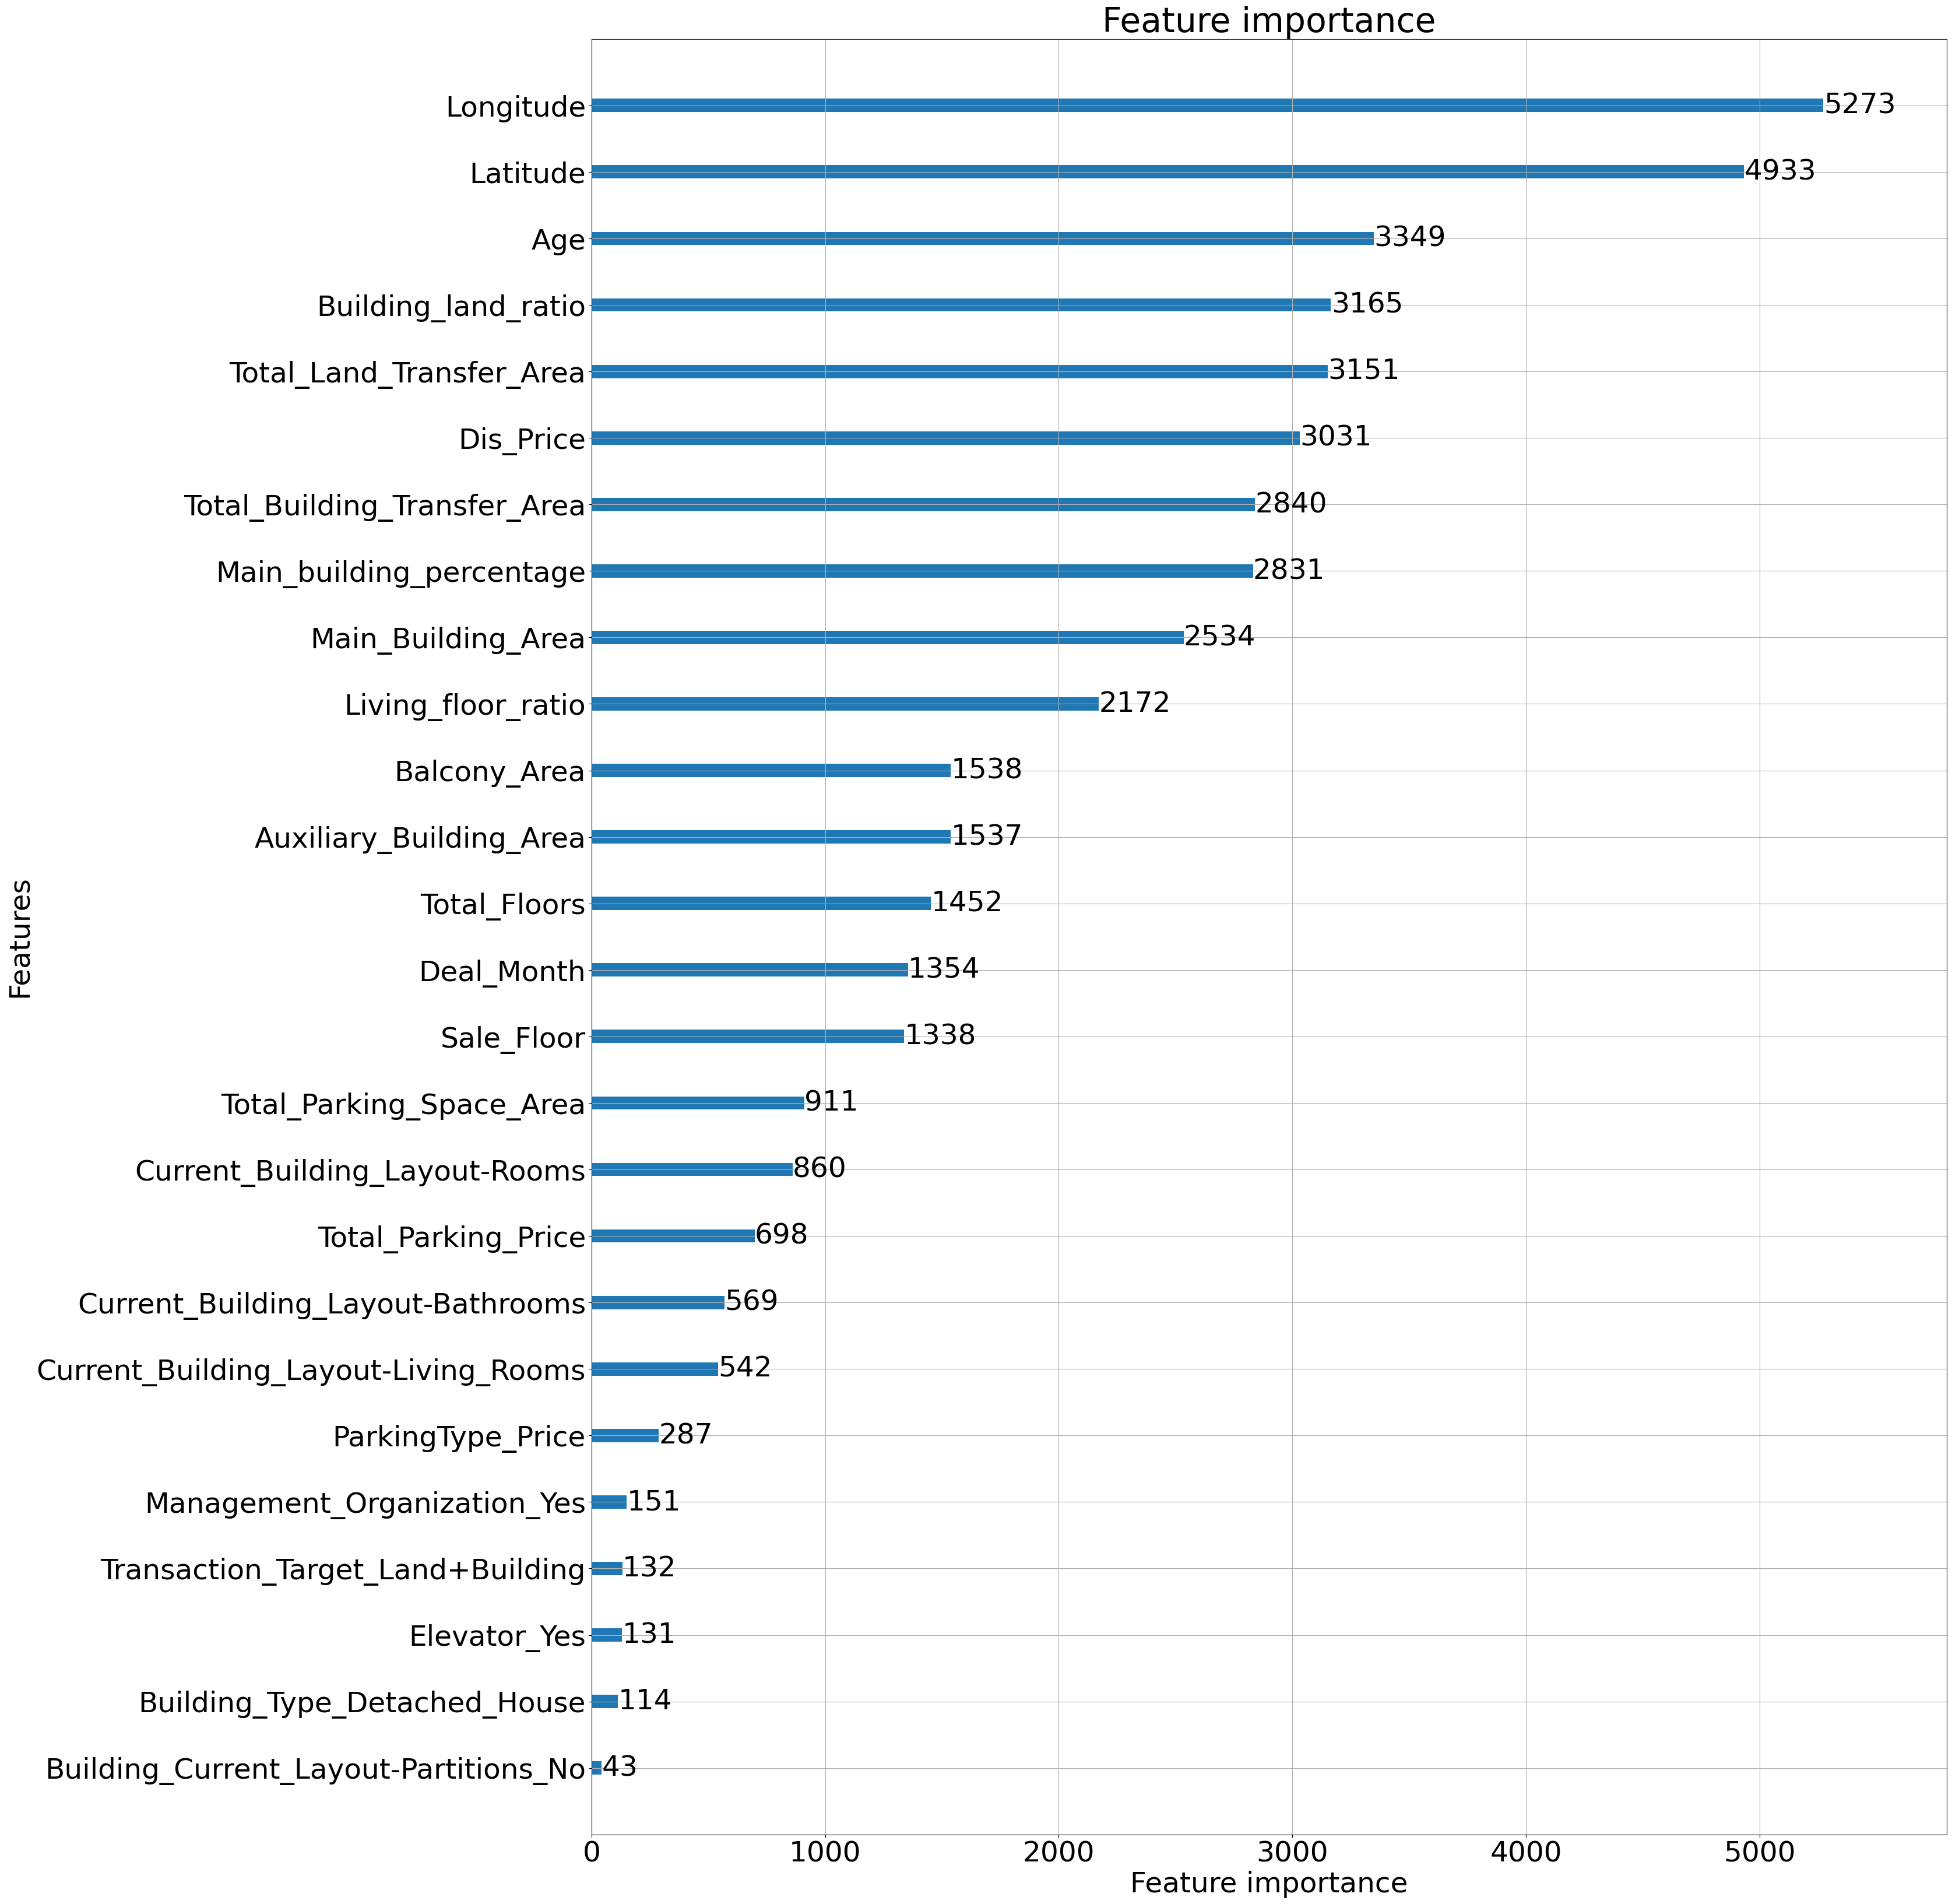

In [23]:
plt.rcParams.update({'font.size': 35})
ax = lgb.plot_importance(lightgbm_model0)
fig = ax.figure
fig.set_size_inches(30, 40)

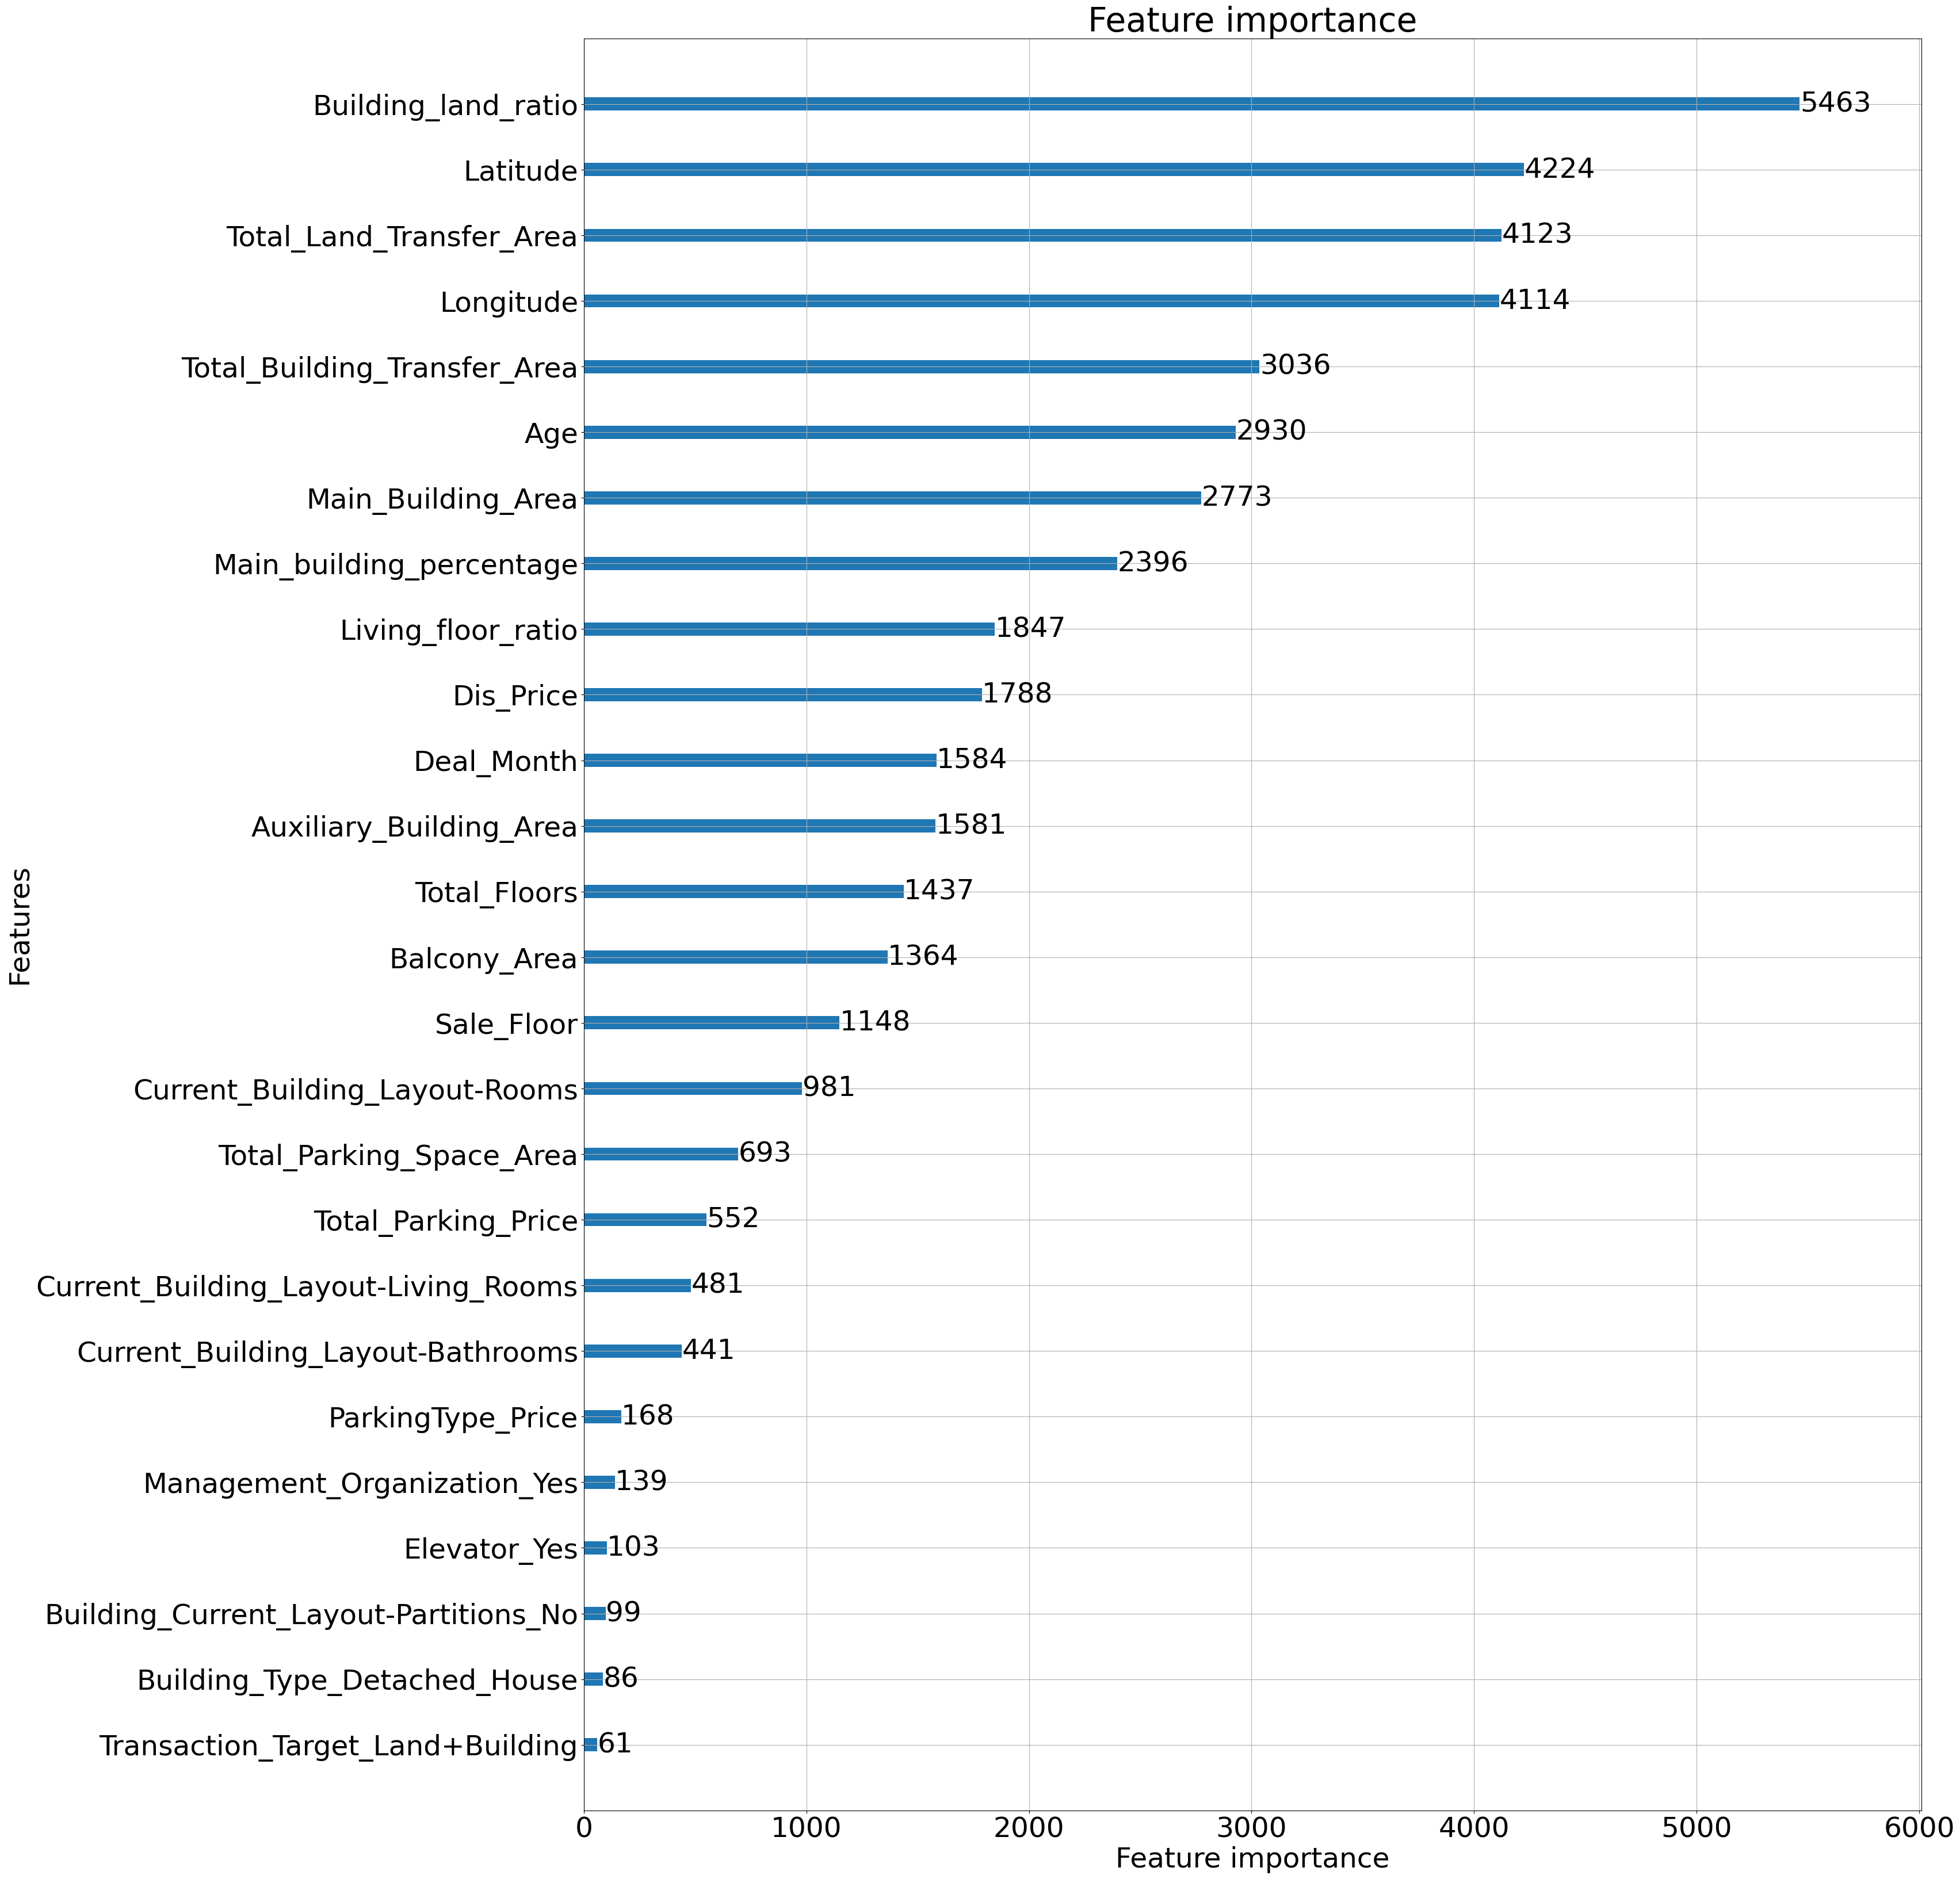

In [24]:
plt.rcParams.update({'font.size': 35})
ax = lgb.plot_importance(lightgbm_model1)
fig = ax.figure
fig.set_size_inches(30, 40)

## Arbitrary Two Stage ML Model

In [25]:
lightgbm_model_taipei = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = 10, max_depth = 5, learning_rate = 0.05, n_estimators = 5000, verbose = -1)
lightgbm_model_newtaipei = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = 10, max_depth = 5, learning_rate = 0.05, n_estimators = 5000, verbose = -1)

lightgbm_model_taipei.fit(X_train_standardize.iloc[train_taipei_index], Y_train.iloc[train_taipei_index])
lightgbm_model_newtaipei.fit(X_train_standardize.iloc[train_newtaipei_index], Y_train.iloc[train_newtaipei_index])

Y_train_hat_gbm_taipei = lightgbm_model_taipei.predict(X_train_standardize.iloc[train_taipei_index])
Y_train_hat_gbm_newtaipei = lightgbm_model_newtaipei.predict(X_train_standardize.iloc[train_newtaipei_index])

train_index = np.concatenate([train_newtaipei_index, train_taipei_index], axis = 0)
Y_train_hat = np.concatenate([Y_train_hat_gbm_newtaipei, Y_train_hat_gbm_taipei], axis = 0)
train_dict = {'index' : train_index, 'predict': Y_train_hat}
train_pd_knowledge = pd.DataFrame(train_dict)
train_pd_knowledge = train_pd_knowledge.sort_values(by = 'index')
train_pd_knowledge.set_index('index', drop = True, inplace = True)

Y_test_hat_gbm_taipei = lightgbm_model_taipei.predict(X_test_standardize.iloc[test_taipei_index])
Y_test_hat_gbm_newtaipei = lightgbm_model_newtaipei.predict(X_test_standardize.iloc[test_newtaipei_index])

test_index = np.concatenate([test_newtaipei_index, test_taipei_index], axis = 0)
Y_test_hat = np.concatenate([Y_test_hat_gbm_newtaipei, Y_test_hat_gbm_taipei], axis = 0)
test_dict = {'Index' : test_index, 'Price': Y_test_hat}
test_pd = pd.DataFrame(test_dict)
test_pd = test_pd.sort_values(by = 'Index')
date = time.ctime(time.time())[:10].replace(' ', '')
test_pd.to_csv(f"test_Knowledge2StageGBM_{date}.csv", index = False)

MAE_gbm = mean_absolute_error(Y_train, train_pd_knowledge['predict'])
print(f"Light GBM Regression: {round(MAE_gbm, 3)}")

Light GBM Regression: 9168.742


In [26]:
district_col = [i for i in X_train.columns if 'District' in i]
training_error_data = {"District": [], "MAE": [], "Number": []}

for i in district_col:
    district_i_index = X_train[X_train[i] == 1][i].index
    Y_train_hat_district_i = train_pd_knowledge['predict'].iloc[district_i_index]
    Y_train_district_i = Y_train.iloc[district_i_index]
    if Y_train_hat_district_i.shape[0]!= 0:
        MAE_gbm_i = mean_absolute_error(Y_train_district_i, Y_train_hat_district_i)
        training_error_data['District'].append(i)
        training_error_data['MAE'].append(MAE_gbm_i)
        training_error_data['Number'].append(Y_train_hat_district_i.shape[0])
    else:
        print(f"----------No training data in {i}----------")
pd.DataFrame(training_error_data).sort_values(by = "MAE")

----------No training data in District_Shiding----------


,District,MAE,Number
36,District_Shuangxi,3286.338746,5
1,District_Sanzhi,3577.212938,147
30,District_Shimen,3882.925472,4
9,District_Bali,3954.461690,356
32,District_Wanli,4221.252389,84
27,District_Tamsui,4823.521862,2322
22,District_Linkou,4981.322755,1104
6,District_Wugu,5025.005326,650
37,District_Yingge,5037.408202,437
34,District_Gongliao,5468.468367,5


## Combined Model

In [27]:
test_pd = pd.read_csv(f"test_2stageGBM_{date}.csv")
test_pd_knowledge = pd.read_csv(f"test_Knowledge2StageGBM_{date}.csv")
test_pd['Price'] = 0.5*(test_pd['Price'] + test_pd_knowledge['Price'])
test_pd.to_csv(f"test_Mix2StageGBM_{date}.csv", index = False)

In [28]:
weights = [i/ 100 for i in range(0, 101)]
MAE_dict = dict()
min_mae = float('inf')
for w in weights:
    train_price = w* train_pd['predict'] + (1 - w)* train_pd_knowledge['predict']
    mae = mean_absolute_error(Y_train, train_price)
    MAE_dict[w] = (mae)
    if mae < min_mae:
        min_mae = mae
        min_weights = w
test_pd['Price'] = min_weights* test_pd['Price'] + (1 - min_weights)*test_pd_knowledge['Price']
test_pd.to_csv(f"test_Mix2StageGBM_optimalweight_{date}.csv", index = False)
print(f"Minimum MAE weight: {min_weights}")

Minimum MAE weight: 0.7


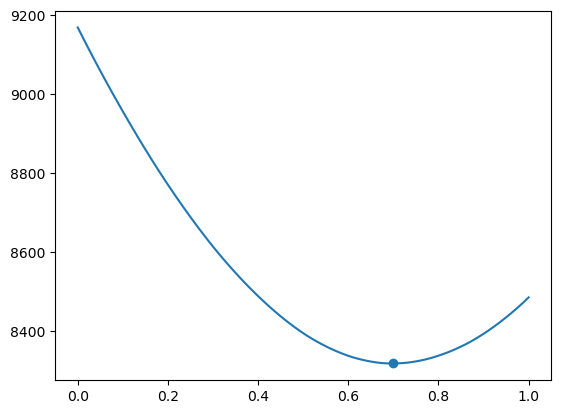

In [29]:
plt.rcParams.update({'font.size': 10})

plt.plot(MAE_dict.keys(), MAE_dict.values())
plt.scatter(min_weights, min_mae)

In [30]:
district_col = [i for i in X_train.columns if 'District' in i]
training_error_data = {"District": [], "MAE": [], "Number": []}

for i in district_col:
    district_i_index = X_train[X_train[i] == 1][i].index
    Y_train_hat_district_i = min_weights* train_pd['predict'].iloc[district_i_index] + (1 - min_weights)* train_pd_knowledge['predict'].iloc[district_i_index]
    Y_train_district_i = Y_train.iloc[district_i_index]
    if Y_train_hat_district_i.shape[0]!= 0:
        MAE_gbm_i = mean_absolute_error(Y_train_district_i, Y_train_hat_district_i)
        training_error_data['District'].append(i)
        training_error_data['MAE'].append(MAE_gbm_i)
        training_error_data['Number'].append(Y_train_hat_district_i.shape[0])
    else:
        print(f"----------No training data in {i}----------")
pd.DataFrame(training_error_data).sort_values(by = "MAE")

----------No training data in District_Shiding----------


,District,MAE,Number
1,District_Sanzhi,3265.315247,147
9,District_Bali,3754.924838,356
32,District_Wanli,3990.135377,84
36,District_Shuangxi,4047.524532,5
29,District_Ruifang,4428.743517,73
27,District_Tamsui,4775.575480,2322
22,District_Linkou,4820.493335,1104
37,District_Yingge,4889.447354,437
6,District_Wugu,5059.304245,650
35,District_Jinshan,5118.710439,56
